## Georgia Tract-Level CO₂ Emissions Mapping

Estimated and visualized per capita CO₂ emissions at the census tract level in two major Georgia counties: Fulton (Atlanta) and Chatham (Savannah). The workflow includes fetching population data, simulating VMT (Vehicle Miles Traveled), computing emissions using EPA emission factors, and rendering interactive maps with Folium.

In [1]:
!pip install geopandas folium censusdata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for censusdata: filename=CensusData-1.15.post1-py3-none-any.whl size=28205744 sha256=712621f4c88e85c0f40b7b358b2f972b0de7d5172b8fd29186768a282728537e
  Stored in directory: /root/.cache/pip/wheels/7c/5b/55/834c5472b44ab5688be29f6009667601fbc13f38cff9dd36e6
Successfully built censusdata


In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium import Choropleth, GeoJsonTooltip
import requests
import zipfile
import io
import os
from google.colab import files
from IPython.display import display

Upload Shapefile

In [4]:
print("Upload the shapefile ZIP (tl_2024_13_tract (1).zip)...")
uploaded = files.upload()

Upload the shapefile ZIP (tl_2024_13_tract (1).zip)...


Saving tl_2024_13_tract (1).zip to tl_2024_13_tract (1).zip


Fetching Data

In [5]:
shapefile_zip = next(iter(uploaded))
extract_path = "/content/ga_tracts"
with zipfile.ZipFile(shapefile_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [6]:
gdf = gpd.read_file(extract_path)

In [7]:
API_KEY = "5d8a3d9ae8fe2e3afebe6630f772a2765ee245a5"
ATLANTA_COUNTY = "121"
SAVANNAH_COUNTY = "051"
STATE_FIPS = "13"

EMISSION_FACTORS = {
    "car": 0.271,
    "truck": 0.611
}

In [8]:
def fetch_population_data(state_fips, county_fips, api_key):
    url = "https://api.census.gov/data/2022/acs/acs5"
    params = {
        "get": "NAME,B01003_001E",
        "for": "tract:*",
        "in": f"state:{state_fips} county:{county_fips}",
        "key": api_key
    }
    response = requests.get(url, params=params)
    data = response.json()
    df = pd.DataFrame(data[1:], columns=data[0])
    df["GEOID"] = df["state"] + df["county"] + df["tract"]
    df["B01003_001E"] = pd.to_numeric(df["B01003_001E"], errors="coerce")
    return df[["GEOID", "B01003_001E"]]

Normalize Function to the scale of the region's Max and Mini

In [9]:
def normalize_series(s):
    return (s - s.min()) / (s.max() - s.min())

Computing Emissions Based on miles travelled

In [10]:
def compute_emissions(subset_gdf, pop_df):
    np.random.seed(42)
    vehicle_df = pd.DataFrame({
        "GEOID": subset_gdf["GEOID"],
        "vmt_car": np.random.randint(50000, 200000, len(subset_gdf)),
        "vmt_truck": np.random.randint(10000, 50000, len(subset_gdf))
    })

    merged = subset_gdf.merge(pop_df, on="GEOID").merge(vehicle_df, on="GEOID")
    merged["emissions_kg"] = (
        merged["vmt_car"] * EMISSION_FACTORS["car"] +
        merged["vmt_truck"] * EMISSION_FACTORS["truck"]
    )

    merged["co2_per_capita"] = merged["emissions_kg"] / merged["B01003_001E"].replace(0, np.nan)
    merged["co2_log"] = np.log1p(merged["co2_per_capita"].clip(lower=0))
    merged["co2_norm"] = normalize_series(merged["co2_log"]).fillna(0)
    return merged

In [11]:
atlanta_result = compute_emissions(atlanta_gdf, pop_df)
atlanta_result.to_file("atlanta_emissions.geojson", driver="GeoJSON")

NameError: name 'atlanta_gdf' is not defined

Mapping in Folium

In [ ]:
def show_map(subset_gdf, label):
    projected = subset_gdf.to_crs(epsg=26917)
    centroid = projected.geometry.centroid.to_crs(epsg=4326)
    lat, lon = centroid.y.mean(), centroid.x.mean()

    m = folium.Map(location=[lat, lon], zoom_start=11, tiles="cartodbpositron")
    Choropleth(
        geo_data=subset_gdf.to_crs(epsg=4326),
        data=subset_gdf,
        columns=["GEOID", "co2_norm"],
        key_on="feature.properties.GEOID",
        fill_color="YlOrRd",
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name="CO₂ Emissions per Capita (normalized)"
    ).add_to(m)

    tooltip = GeoJsonTooltip(fields=["GEOID", "co2_per_capita"], aliases=["Tract:", "CO₂ per Capita (kg):"])
    folium.GeoJson(subset_gdf.to_crs(epsg=4326), tooltip=tooltip).add_to(m)

    html_path = f"/content/{label.lower()}_emissions_map.html"
    m.save(html_path)
    print(f"{label} emissions map saved to: {html_path}")

Visualizing the Maps

In [ ]:
pop_df = pd.concat([
    fetch_population_data(STATE_FIPS, ATLANTA_COUNTY, API_KEY),
    fetch_population_data(STATE_FIPS, SAVANNAH_COUNTY, API_KEY)
])

atlanta_gdf = gdf[gdf["COUNTYFP"] == ATLANTA_COUNTY].copy()
savannah_gdf = gdf[gdf["COUNTYFP"] == SAVANNAH_COUNTY].copy()

atlanta_result = compute_emissions(atlanta_gdf, pop_df)
savannah_result = compute_emissions(savannah_gdf, pop_df)

show_map(atlanta_result, "Atlanta")
show_map(savannah_result, "Savannah")

Atlanta emissions map saved to: /content/atlanta_emissions_map.html
Savannah emissions map saved to: /content/savannah_emissions_map.html


In [ ]:
from IPython.display import display

def show_map(subset_gdf, label):
    projected = subset_gdf.to_crs(epsg=26917)
    centroid = projected.geometry.centroid.to_crs(epsg=4326)
    lat, lon = centroid.y.mean(), centroid.x.mean()

    m = folium.Map(location=[lat, lon], zoom_start=11, tiles="cartodbpositron")
    Choropleth(
        geo_data=subset_gdf.to_crs(epsg=4326),
        data=subset_gdf,
        columns=["GEOID", "co2_norm"],
        key_on="feature.properties.GEOID",
        fill_color="YlOrRd",
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name="CO₂ Emissions per Capita (normalized)"
    ).add_to(m)

    tooltip = GeoJsonTooltip(fields=["GEOID", "co2_per_capita"], aliases=["Tract:", "CO₂ per Capita (kg):"])
    folium.GeoJson(subset_gdf.to_crs(epsg=4326), tooltip=tooltip).add_to(m)

    display(m)  # This will show the map inside the notebook

/tmp/ipython-input-12-3246085159.py:9: FutureWarning: WKBReadingError is deprecated and will be removed in a future version. Use ShapelyError instead (functions previously raising {name} will now raise a ShapelyError instead).
  from shapely.errors import WKBReadingError


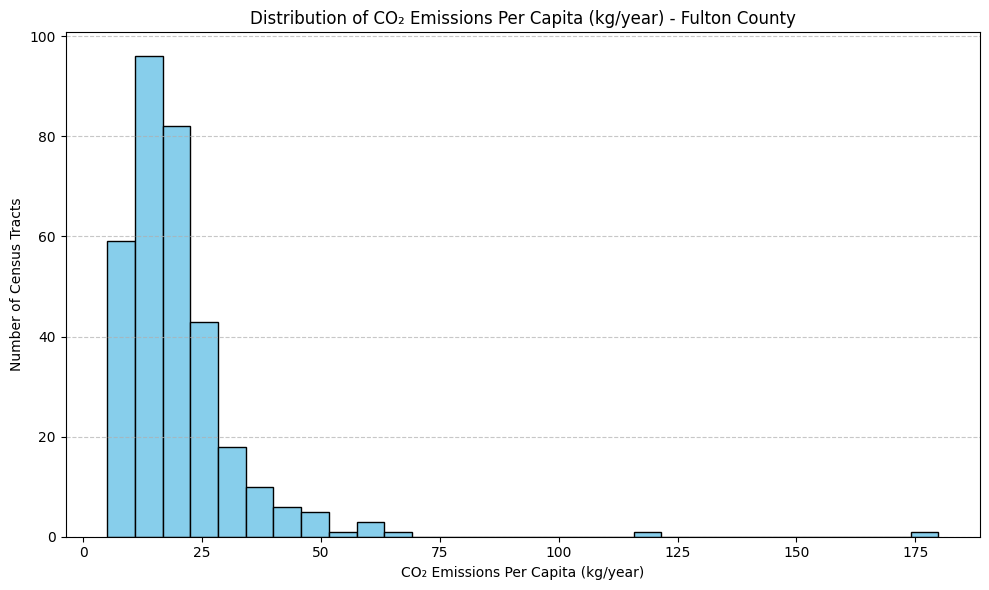

In [12]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import requests
from shapely.wkb import loads
from shapely.errors import WKBReadingError

# === CONFIG ===
ZIP_PATH = "/content/tl_2024_13_tract (1).zip"  # adjust if different
EXTRACT_DIR = "/content/ga_tracts"
API_KEY = "5d8a3d9ae8fe2e3afebe6630f772a2765ee245a5"
STATE_FIPS = "13"
ATLANTA_COUNTY = "121"
EMISSION_FACTORS = {"car": 0.271, "truck": 0.611}

# === FUNCTIONS ===
def normalize_series(s):
    return (s - s.min()) / (s.max() - s.min())

def fetch_population_data(state_fips, county_fips, api_key):
    url = "https://api.census.gov/data/2022/acs/acs5"
    params = {
        "get": "NAME,B01003_001E",
        "for": "tract:*",
        "in": f"state:{state_fips} county:{county_fips}",
        "key": api_key
    }
    response = requests.get(url, params=params)
    data = response.json()
    df = pd.DataFrame(data[1:], columns=data[0])
    df["GEOID"] = df["state"] + df["county"] + df["tract"]
    df["B01003_001E"] = pd.to_numeric(df["B01003_001E"], errors="coerce")
    return df[["GEOID", "B01003_001E"]]

def compute_emissions(subset_gdf, pop_df):
    np.random.seed(42)
    vehicle_df = pd.DataFrame({
        "GEOID": subset_gdf["GEOID"],
        "vmt_car": np.random.randint(50000, 200000, len(subset_gdf)),
        "vmt_truck": np.random.randint(10000, 50000, len(subset_gdf))
    })
    merged = subset_gdf.merge(pop_df, on="GEOID").merge(vehicle_df, on="GEOID")
    merged["emissions_kg"] = (
        merged["vmt_car"] * EMISSION_FACTORS["car"] +
        merged["vmt_truck"] * EMISSION_FACTORS["truck"]
    )
    merged["co2_per_capita"] = merged["emissions_kg"] / merged["B01003_001E"].replace(0, np.nan)
    merged["co2_log"] = np.log1p(merged["co2_per_capita"].clip(lower=0))
    merged["co2_norm"] = normalize_series(merged["co2_log"]).fillna(0)
    return merged

# === STEP 1: Extract the ZIP ===
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

# === STEP 2: Load shapefile with safe geometry parsing ===
raw = gpd.read_file(os.path.join(EXTRACT_DIR, "tl_2024_13_tract.shp"))
raw = raw[raw["COUNTYFP"] == ATLANTA_COUNTY].copy()

# Fix geometry parsing
def safe_parse(geom):
    try:
        return loads(geom.wkb)
    except:
        return None

raw["geometry"] = raw["geometry"].apply(safe_parse)
atlanta_gdf = raw.dropna(subset=["geometry"])

# === STEP 3: Fetch population and compute emissions ===
pop_df = fetch_population_data(STATE_FIPS, ATLANTA_COUNTY, API_KEY)
atlanta_result = compute_emissions(atlanta_gdf, pop_df)

# === STEP 4: Save GeoJSON ===
atlanta_result.to_file("/content/atlanta_emissions.geojson", driver="GeoJSON")

# === STEP 5: Plot histogram ===
plt.figure(figsize=(10, 6))
plt.hist(atlanta_result["co2_per_capita"].dropna(), bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of CO₂ Emissions Per Capita (kg/year) - Fulton County")
plt.xlabel("CO₂ Emissions Per Capita (kg/year)")
plt.ylabel("Number of Census Tracts")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/tmp/ipython-input-13-534451419.py:9: FutureWarning: WKBReadingError is deprecated and will be removed in a future version. Use ShapelyError instead (functions previously raising {name} will now raise a ShapelyError instead).
  from shapely.errors import WKBReadingError


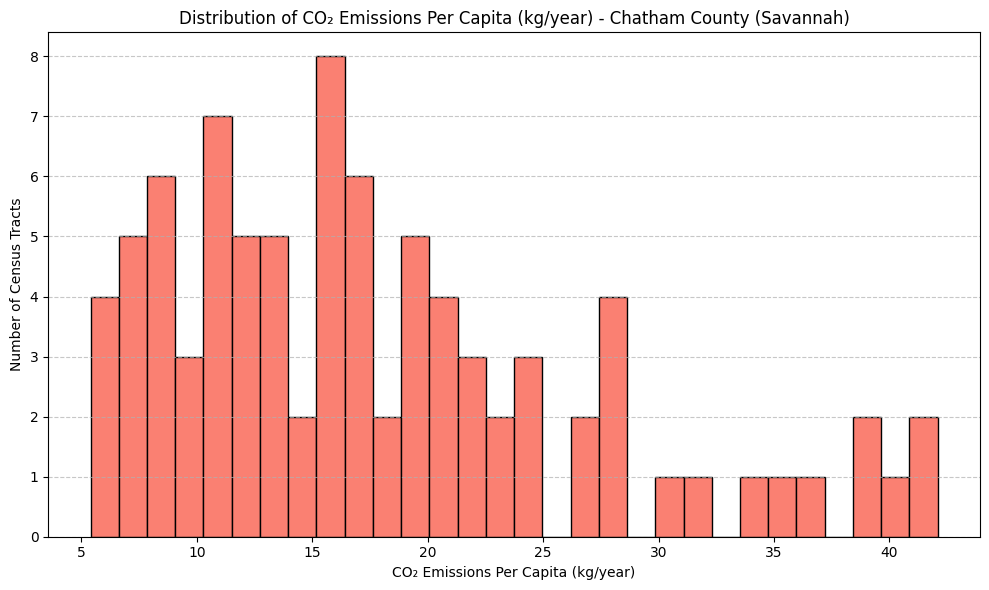

In [13]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import requests
from shapely.wkb import loads
from shapely.errors import WKBReadingError

# === CONFIG ===
ZIP_PATH = "/content/tl_2024_13_tract (1).zip"  # same zip, covers all of GA
EXTRACT_DIR = "/content/ga_tracts"
API_KEY = "5d8a3d9ae8fe2e3afebe6630f772a2765ee245a5"
STATE_FIPS = "13"
SAVANNAH_COUNTY = "051"
EMISSION_FACTORS = {"car": 0.271, "truck": 0.611}

# === FUNCTIONS ===
def normalize_series(s):
    return (s - s.min()) / (s.max() - s.min())

def fetch_population_data(state_fips, county_fips, api_key):
    url = "https://api.census.gov/data/2022/acs/acs5"
    params = {
        "get": "NAME,B01003_001E",
        "for": "tract:*",
        "in": f"state:{state_fips} county:{county_fips}",
        "key": api_key
    }
    response = requests.get(url, params=params)
    data = response.json()
    df = pd.DataFrame(data[1:], columns=data[0])
    df["GEOID"] = df["state"] + df["county"] + df["tract"]
    df["B01003_001E"] = pd.to_numeric(df["B01003_001E"], errors="coerce")
    return df[["GEOID", "B01003_001E"]]

def compute_emissions(subset_gdf, pop_df):
    np.random.seed(42)
    vehicle_df = pd.DataFrame({
        "GEOID": subset_gdf["GEOID"],
        "vmt_car": np.random.randint(50000, 200000, len(subset_gdf)),
        "vmt_truck": np.random.randint(10000, 50000, len(subset_gdf))
    })
    merged = subset_gdf.merge(pop_df, on="GEOID").merge(vehicle_df, on="GEOID")
    merged["emissions_kg"] = (
        merged["vmt_car"] * EMISSION_FACTORS["car"] +
        merged["vmt_truck"] * EMISSION_FACTORS["truck"]
    )
    merged["co2_per_capita"] = merged["emissions_kg"] / merged["B01003_001E"].replace(0, np.nan)
    merged["co2_log"] = np.log1p(merged["co2_per_capita"].clip(lower=0))
    merged["co2_norm"] = normalize_series(merged["co2_log"]).fillna(0)
    return merged

# === STEP 1: Extract the ZIP ===
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

# === STEP 2: Load shapefile with safe geometry parsing ===
raw = gpd.read_file(os.path.join(EXTRACT_DIR, "tl_2024_13_tract.shp"))
raw = raw[raw["COUNTYFP"] == SAVANNAH_COUNTY].copy()

def safe_parse(geom):
    try:
        return loads(geom.wkb)
    except:
        return None

raw["geometry"] = raw["geometry"].apply(safe_parse)
savannah_gdf = raw.dropna(subset=["geometry"])

# === STEP 3: Fetch population and compute emissions ===
pop_df = fetch_population_data(STATE_FIPS, SAVANNAH_COUNTY, API_KEY)
savannah_result = compute_emissions(savannah_gdf, pop_df)

# === STEP 4: Save GeoJSON ===
savannah_result.to_file("/content/savannah_emissions.geojson", driver="GeoJSON")

# === STEP 5: Plot histogram ===
plt.figure(figsize=(10, 6))
plt.hist(savannah_result["co2_per_capita"].dropna(), bins=30, color="salmon", edgecolor="black")
plt.title("Distribution of CO₂ Emissions Per Capita (kg/year) - Chatham County (Savannah)")
plt.xlabel("CO₂ Emissions Per Capita (kg/year)")
plt.ylabel("Number of Census Tracts")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()